In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [14]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import spdiags, identity
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances


from scipy.linalg import qr
def clusterpqr(X):
    
    n_clusters = X.shape[1]
    _,_,p = qr(X.T, mode = 'economic', pivoting = True)
    
    p = p[:n_clusters]
    ut,_,vth = np.linalg.svd(X[p,:].T, full_matrices = False)
    
    U = np.dot(X,np.dot(ut,vth))
    labels = np.argmax(np.abs(U), axis = 1)
    
    return labels


def spectralsegmentation(W, method = 'normalized', n_clusters = None):
 
    
    #Compute degree of the matrix
    d = W.sum(axis = 1).flatten()
    D = spdiags(d,0,W.shape[0],W.shape[1])
    
    
    # Construct the appropriate laplacian and the eigenvectors
    if method == 'unnormalized':
        d = W.sum(axis = 1).flatten()
        D = np.diag(d,0)
        L = D - W
        
        l, v = eigsh(L, k = n_clusters, which = 'SM')
        X = v
        
    elif method == 'normalized': 
        # Computing the largest eigenvalues of D^{-1/2}WD^{-1/2}
        # equivalent to computing the smallest eigenvalues of L_sym = I - D^{-1/2}WD^{-1/2}
        
        Dinv12 = spdiags(1./np.sqrt(d),0,W.shape[0],W.shape[1])
        A = Dinv12.dot(W.dot(Dinv12))
        
        #This step can be replaced by a randomized subspace iteration
        l, v = eigsh(A, k = n_clusters)
        
        #Scale the rows by the row norms to normalized the vectors
        X = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, v)
    else:
        raise NotImplementedError
    


    labels = clusterpqr(X)
    
    return labels

## 1. Example 1: Simple image

Text(0.5,1,'Noisy image')

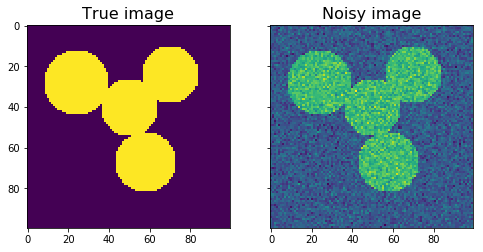

In [15]:
### Create the example image
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

mask = img.astype(bool)
img = img.astype(float)
imgn =  img + 1 + 0.2 * np.random.randn(*img.shape)

f, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax1.imshow(img)
ax1.set_title('True image', fontsize = 16)
ax2.imshow(imgn)
ax2.set_title('Noisy image', fontsize = 16)

In [16]:
# Convert the image into a graph with the value of the gradient on the
# edges.
from sklearn.feature_extraction import image
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectralsegmentation(graph, method = 'normalized', n_clusters = 4)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

Text(0.5,1,'Clustered image')

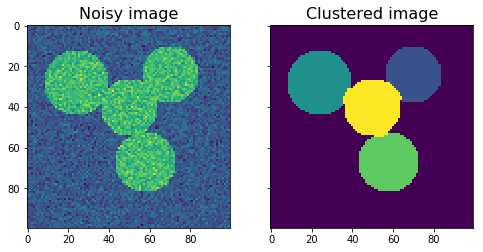

In [17]:
### Plot the images 

f, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,4))
ax1.imshow(imgn)
ax1.set_title('Noisy image', fontsize = 16)
ax2.imshow(label_im)
ax2.set_title('Clustered image', fontsize = 16)

## Example 2: More challenging image

In [24]:
from scipy.ndimage import imread
A = imread('figs/RainbowDash.jpg', flatten = True)

(1080, 1920)


2073600